In [1]:
import numpy as np
import os
import pandas as pd
import tables as tb
from glob import glob

import matplotlib.pyplot as plt
import invisible_cities.io.dst_io as dio

from matplotlib.patches import Patch

From Gonzalo's thesis, he does a selection following the next cuts:

* **nexus**: picks the events that have a total energy inside the energy range
* **reco**: picks the events that have passed the reconstruction (I guess after Beersheba)
* **ene**: picks the events that have a total energy inside the energy range AFTER the reconstruction (due to energy corrections)
* **fid**: picks the events that have a R center of mass (hit transversal position weighted with energy) such as R < 45 cm (4cm from the chamber edges) and a Z center of mass of 2 < Z < 116 cm (2cm from the electrodes). It is correlated with the previous cut as the high radius events are corrected worse and have less energy than they should so are already removed.
* **track**: picks the events with 1 single reconstructed track (isaura)
* **ovl**: removes events where the track defined blobs have any bit of overlap

These are the analysis selections. For discrimination selections, we have two options:
* **ROI**: selects the events based on an optimal energy window where the f.o.m. is maximized, in Gonzalo's analysis is [2.456, 2.472] MeV 
* **topo**: selects the events based on the energy of the least energetic blob, in this case picks the events with an energy > 0.57 MeV

In [10]:
base_dir = '/mnt/netapp1/Store_next_data/mperez/NEXT100/data/my_prod_0nubb/prod/'


In [11]:
sort_files = lambda x: int(x.split('_')[-2])

In [12]:
def remove_spurious_tracks(tracks, spurious_energy):
    sel_spurious = (tracks.energy < 0.01)
    spurious_energies = tracks.loc[sel_spurious].groupby('event').energy.sum().reset_index().rename(columns={'energy':'spurious_ene'})
    spurious_energies['trackID'] = 0
    
    tracks = tracks.merge(spurious_energies, on = ['event', 'trackID'], how = 'outer')
    tracks['spurious_ene'] = tracks['spurious_ene'].fillna(0)

    tracks['energy'] = tracks['energy'] + tracks['spurious_ene']
    tracks = tracks.loc[~sel_spurious].drop('spurious_ene', axis = 1)
    tracks = tracks.drop('numb_of_tracks', axis = 1).merge(tracks.groupby('event').trackID.nunique().reset_index().rename(columns={'trackID':'numb_of_tracks'}), on = 'event')
    return tracks

In [14]:
# isaura_files = sorted(glob(base_dir + 'isaura/*'), key=sort_files)
# nexus_files = sorted(glob(base_dir + 'nexus/*'), key=sort_files)[:len(isaura_files)]

# nexus, reco, ener, fid, track, ovl, roi, topo = 0,0,0,0,0,0,0,0
# for isaura_file, nexus_file in zip(isaura_files, nexus_files):
#     #NEXUS
#     nexus_df = dio.load_dst(nexus_file, 'MC', 'particles')
#     nexus += len(nexus_df.event_id.unique())

#     #RECO
#     isa_df = dio.load_dst(isaura_file, 'Tracking', 'Tracks')
#     #isa_df = remove_spurious_tracks(isa_df, 0.01)
#     reco += len(isa_df.event.unique())

#     #ENE
#     isa_df_ = isa_df.merge(isa_df.groupby('event').sum().reset_index()[['event', 'energy']].rename(columns = {'energy':'tot_ener'}), on = ['event'])

#     isa_df_ene = isa_df_[(isa_df_.tot_ener > 2.4) & (isa_df_.tot_ener < 2.5)]
#     ener += len(isa_df_ene.event.unique())

#     #FID
#     isa_df_fid = isa_df_ene[(isa_df_ene.r_max < 450) & (isa_df_ene.z_min > 20) & (isa_df_ene.z_max < 1160)]
#     fid += len(isa_df_fid.event.unique())

#     #TRACK
#     isa_df_track = isa_df_fid[isa_df_fid.numb_of_tracks == 1]
#     track += len(isa_df_track)

#     #OVL
#     isa_df_ovl = isa_df_track[isa_df_track.ovlp_blob_energy == 0]
#     ovl += len(isa_df_ovl)

#     #ROI
#     isa_df_roi = isa_df_ovl[(isa_df_ovl.tot_ener > 2.456) & (isa_df_ovl.tot_ener < 2.472)]
#     roi += len(isa_df_roi)

#     #TOPO
#     isa_df_topo = isa_df_roi[isa_df_roi.eblob2 > 0.57]
#     topo += len(isa_df_topo)

#     print(isaura_file.split('_')[-2], nexus, reco, ener, fid, fid, track, ovl, roi, topo)
# df_dct = {'nexus':nexus, 'reco':reco, 'ener':ener,
#           'fid':fid, 'track':track, 'ovl':ovl, 
#           'roi':roi, 'topo':topo}
# final_df = pd.DataFrame([df_dct])

1 200 175 114 109 109 93 92 66 48
2 400 347 233 220 220 183 181 122 84
3 600 526 347 323 323 266 262 172 117
4 800 704 459 420 420 351 346 233 150
5 1000 872 573 520 520 428 423 283 181
6 1200 1034 689 626 626 515 509 342 221
7 1400 1198 795 720 720 592 585 396 257
8 1600 1366 901 821 821 680 672 455 290
9 1800 1534 1018 929 929 770 762 522 332
10 2000 1700 1130 1030 1030 857 848 587 373
11 2200 1873 1237 1131 1131 946 936 645 418
12 2400 2033 1340 1226 1226 1025 1014 702 450
13 2600 2205 1452 1327 1327 1101 1090 747 480
14 2800 2373 1553 1422 1422 1189 1176 812 520
15 3000 2537 1656 1515 1515 1269 1256 867 553
16 3200 2697 1758 1606 1606 1349 1336 922 590
17 3400 2852 1855 1694 1694 1429 1411 965 616
18 3600 3017 1961 1787 1787 1514 1494 1029 661
19 3800 3184 2066 1883 1883 1597 1574 1082 697
20 4000 3352 2169 1977 1977 1676 1652 1140 734
21 4200 3513 2278 2081 2081 1764 1740 1196 769
22 4400 3671 2380 2173 2173 1842 1818 1252 807
23 4600 3833 2490 2275 2275 1923 1896 1306 841
24 4800

In [15]:
fileout = base_dir + '0nubb_rates_selection_spurious.h5'
# with tb.open_file(fileout, 'a') as h5out:
#     dio.df_writer(h5out, final_df  , '0nubb', 'selection_rates')

/mnt/netapp2/Store_uni/home/usc/ie/mpm/conda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0nubb'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [16]:
rates_0nubb = dio.load_dst(fileout, '0nubb', 'selection_rates')

In [17]:
rates_0nubb = rates_0nubb.apply(lambda x: x/rates_0nubb.nexus.values)

In [19]:
rates_0nubb

,nexus,reco,ener,fid,track,ovl,roi,topo
0,1.0,0.834738,0.544918,0.49572,0.410162,0.402813,0.276568,0.177285


Text(0, 0.5, 'efficiency')

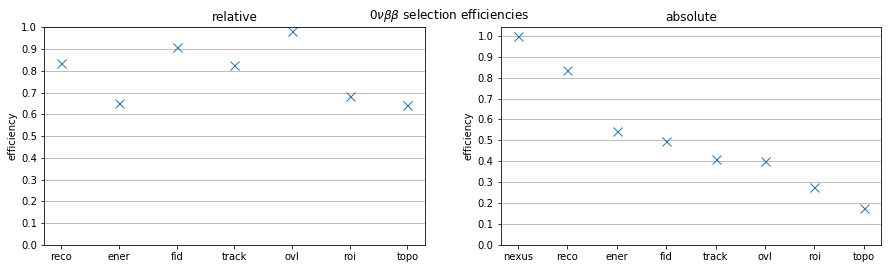

In [18]:
plt.figure(figsize=[15, 4])
plt.suptitle(r"0$\nu\beta\beta$ selection efficiencies", y=0.95)

plt.subplot(121)
plt.title("relative")
plt.plot(rates_0nubb.T / rates_0nubb.T.shift(1), 'x', markersize = 9)
plt.grid(axis="y")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("efficiency")

plt.subplot(122)
plt.title("absolute")
plt.plot(rates_0nubb.T, 'x', markersize=9)
plt.grid(axis="y")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("efficiency")

In [20]:
def read_act_and_sim(isotope, 
                     act_path = '/home/usc/ie/mpm/NEXT100-0nubb-analysis/nexus_job_templates/ft3/backgrounds/activities_efficiencies_upd2.ods',
                     st_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/event_stats.txt',
                     vol_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/{}/'):
    st_path = st_path.format(isotope)

    year = (3600 * 24 * 365) / 1000

    activities = dict(pd.read_excel(act_path, sheet_name=isotope, engine='odf').set_index("G4Volume").TotalActivity)

    with open(st_path, 'r') as f:
        text = f.readlines()
        f.close()
    sim_evs = {t.split(' ')[-4].split('/')[-1]:int(t.split(' ')[-2])*int(t.split(' ')[1]) for t in text}
    sim_evs_red = {t.split(' ')[-4].split('/')[-1]:int(t.split(' ')[-2])*len(glob(vol_path.format(isotope, t.split(' ')[-4].split('/')[-1]) + 'prod/detsim/*')) for t in text}
    activities = {k: activities[k] for k in sorted(activities)}
    sim_evs = {k: sim_evs[k] for k in sorted(sim_evs)}
    sim_evs_red = {k: sim_evs_red[k] for k in sorted(sim_evs_red)}

    act = pd.DataFrame([activities]).T.reset_index().rename(columns = {'index': 'vol', 0:'activities'})
    sim = pd.DataFrame([sim_evs]).T.reset_index().rename(columns = {'index': 'vol', 0:'sim'})
    sim_red = pd.DataFrame([sim_evs_red]).T.reset_index().rename(columns = {'index': 'vol', 0:'sim_red'})
    sim_act = act.merge(sim, on = 'vol')
    sim_act = sim_act.merge(sim_red, on = 'vol')
    sim_act['exposure'] = sim_act.sim / (sim_act.activities * year)
    sim_act['reduced_exp'] = sim_act.sim_red / (sim_act.activities * year)

    return sim_act

In [21]:
from invisible_cities.database.load_db     import RadioactivityData

In [24]:
isotope = '208Tl'
bi_act = read_act_and_sim(isotope)[['vol', 'activities']].rename(columns = {'vol':'G4Volume'})

gonz_act = RadioactivityData('next100')[0]
bi_gonz_act = gonz_act[gonz_act.Isotope == isotope].drop('Isotope', axis = 1).reset_index(drop = True)

In [25]:
bi_act

,G4Volume,activities
0,ANODE_RING,0.051898
1,CATHODE_RING,0.050348
2,DB_PLUG,117.940704
3,EP_COPPER_PLATE,47.300803
4,FIELD_RING,2.686026
5,GATE_RING,0.051893
6,HDPE_TUBE,0.373952
7,ICS,7.684907
8,LIGHT_TUBE,7.965568
9,OPTICAL_PAD,3.191472


In [39]:
bi_act.activities - bi_gonz_act.TotalActivity

0      -3.583758
1      -3.468906
2       0.120000
3    -223.978121
4      -4.037644
5      -3.583876
6       0.000860
7    -133.984074
8       1.555623
9       0.000000
10      0.080000
11      0.000000
12     -1.080000
13     57.170829
14      1.130000
15     -0.050000
16     -0.200000
17     13.835891
18   -241.719185
19      2.540000
dtype: float64

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
dtype: float64

In [9]:
analysis_filename = "/home/usc/ie/mpm/NEXT100-0nubb-analysis/analysis/tracks_2.4_2.5_MeV.h5"

In [12]:
import pickle5 as pickle
with open(analysis_filename, "r", errors='ignore') as h5in:
  data = h5in.read()

In [54]:
isotope = '208Tl'
with tb.open_file(analysis_filename, 'r') as h5in:
    #pd.read_hdf(h5in)
    dfs = []
    for i in (1, 0):
        columns  = getattr(getattr(h5in.root, isotope), 'block{}_items'.format(i)).read()
        content  = getattr(getattr(h5in.root, isotope), 'block{}_values'.format(i)).read()
        columns = [st.decode('UTF-8') for st in columns]
        df = pd.DataFrame(content, columns=columns)
        dfs.append(df)

In [55]:
pd.concat(dfs, axis = 1)

,event,trackID,numb_of_voxels,numb_of_hits,numb_of_tracks,file,energy,length,x_min,y_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,62000106,0,106,6215,1,32,2.413124,154.485152,-227.325,-50.325,...,530.702673,-214.981634,-42.891901,558.366758,1.051362,0.321317,0.000000,9.000000,9.636364,4.728098
1,276000008,0,92,7076,1,139,2.414687,124.284721,6.675,-84.325,...,536.471292,38.856488,-77.687130,604.044266,1.257003,0.306343,0.000000,9.750000,9.222222,4.879465
2,232000024,0,105,6584,1,117,2.422876,129.396163,18.675,-328.325,...,511.501014,81.106693,-306.913418,573.517578,0.964909,0.918825,0.000000,9.857143,9.333333,4.773608
3,36,0,130,6793,3,1,2.362764,232.556506,-119.325,-331.325,...,44.199831,-113.505870,-327.241202,109.790486,0.853837,0.208750,0.000000,10.000000,10.000000,4.952347
4,36,1,2,76,3,1,0.021805,10.000000,-102.325,-320.325,...,80.855024,-98.054286,-317.627348,80.869336,0.021805,0.021805,0.021805,10.000000,10.000000,4.952347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63241,3137674,2,2,74,3,118,0.047017,9.250000,-276.325,288.675,...,1089.377039,-271.433730,293.970627,1088.612341,0.047017,0.047017,0.047017,9.500000,9.250000,4.961713
63242,2788906,0,74,5304,2,105,2.372751,86.144109,-92.325,-188.325,...,1161.997494,-9.466117,-165.976341,1177.695360,0.906325,0.160151,0.000000,9.866667,9.769231,4.943913
63243,2788906,1,2,137,2,105,0.070149,4.943913,342.675,56.675,...,1183.936528,346.978796,61.928448,1187.837095,0.070149,0.070149,0.070149,9.866667,9.769231,4.943913
63244,2789092,0,129,6600,2,105,2.168464,172.105076,-239.325,-429.325,...,1053.696100,-232.521002,-396.551830,1151.599803,0.781512,0.203372,0.000000,9.363636,9.842105,4.878740


In [119]:
content[0:20]

array([0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 3, 0, 1, 0, 0, 1, 2])

In [21]:
cosa1[np.isin(cosa1, columns)]

array([b'event', b'trackID', b'numb_of_voxels', b'numb_of_hits',
       b'numb_of_tracks', b'file'], dtype='|S16')

In [17]:
columns

array([b'energy', b'length', b'x_min', b'y_min', b'z_min', b'r_min',
       b'x_max', b'y_max', b'z_max', b'r_max', b'x_ave', b'y_ave',
       b'z_ave', b'r_ave', b'extreme1_x', b'extreme1_y', b'extreme1_z',
       b'extreme2_x', b'extreme2_y', b'extreme2_z', b'blob1_x',
       b'blob1_y', b'blob1_z', b'blob2_x', b'blob2_y', b'blob2_z',
       b'eblob1', b'eblob2', b'ovlp_blob_energy', b'vox_size_x',
       b'vox_size_y', b'vox_size_z'], dtype='|S16')

In [126]:
cosa2

array([0, 0, 0, ..., 1, 2, 3])